In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import json
from torch.utils.data import DataLoader , TensorDataset

In [ ]:
df = pd.read_csv('telemetry_watch.csv')
df

In [ ]:

with open('grmsx_labels.json') as user_file:
  file_contents = user_file.read()
  

parsed_json = json.loads(file_contents)
parsed_json = parsed_json[0]

parsed_json= parsed_json['annotations'][0]['result']
parsed_json

labels = []

labels_gx = []


for i in range(436):
    labels_gx.append('label')


for elem in parsed_json:
    start_idx = elem['value']['start']
    end_idx = elem['value']['end']
    label = elem['value']['timeserieslabels'][0]
    
    for i in range(start_idx, end_idx + 1 ):
        labels_gx[i] = label


labels.append(labels_gx)
labels= labels[0]
print(len(labels_gx))
len(labels)


436


436

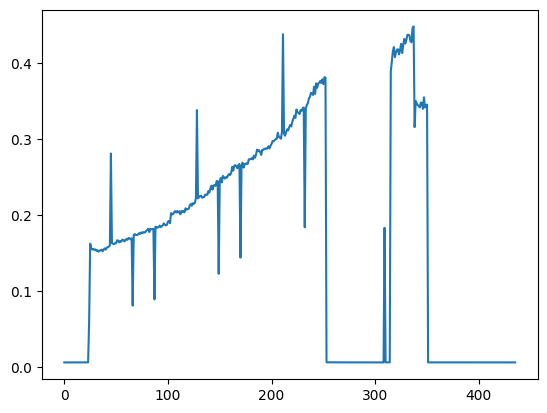

In [ ]:
training_set  = df.GRMS_X

plt.plot(training_set, label = 'GRMS_X Values')
plt.show()



In [ ]:
# Data Loading

def sliding_windows(data,seq_length):
    x = []
    y = []
    
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    
    return np.array(x), np.array(y)

scaler = MinMaxScaler()
training_set = training_set.values.reshape(-1,1)
training_data = scaler.fit_transform(training_set)

seq_length = 4

x, y = sliding_windows(training_set, seq_length) 

train_size = 436
test_size = 436
#dataX = torch.Tensor(np.array(x))
#dataY = torch.Tensor(np.array(y))

#trainX = torch.Tensor(np.array(x[0:train_size]))
#trainY = torch.Tensor(np.array(y[0:train_size]))

#testX = torch.Tensor(np.array(x[train_size : len(x)]))
#testY = torch.Tensor(np.array(y[train_size: len(y)]))

# trainX.shape

train_dataset = TensorDataset(torch.Tensor(x), torch.Tensor(y))
test_dataset = TensorDataset(torch.Tensor(x), torch.Tensor(y))

train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=48, shuffle=False)

x[0]


array([[0.00637486],
       [0.00642695],
       [0.00640269],
       [0.00638894]])

In [ ]:
# Model

class LSTMModel(nn.Module):
    def __init__(self,num_classes, input_size, hidden_size,num_layers):
        super(LSTMModel, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                            num_layers = num_layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_size,num_classes)
        
    #def forward(self,x):
        
    #    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    #    c_0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size)
        
    #    u, (h_out, _) = self.lstm(x, (h_0, c_0))
        
    #    h_out = h_out.view(-1,self.hidden_size)
        
    #    out = self.fc(h_out)
        
    #    return out
    
    

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  
        return out


Epoch [1/2000], Loss: 0.11792177706956863


Epoch [101/2000], Loss: 0.022574709728360176
Epoch [201/2000], Loss: 0.023798180744051933
Epoch [301/2000], Loss: 0.022248266264796257
Epoch [401/2000], Loss: 0.01735956408083439
Epoch [501/2000], Loss: 0.013076935894787312
Epoch [601/2000], Loss: 0.008872637525200844
Epoch [701/2000], Loss: 0.00511044031009078
Epoch [801/2000], Loss: 0.0051594688557088375
Epoch [901/2000], Loss: 0.0021885735914111137
Epoch [1001/2000], Loss: 0.0011595223331823945
Epoch [1101/2000], Loss: 0.00018219961202703416
Epoch [1201/2000], Loss: 0.0008573849336244166
Epoch [1301/2000], Loss: 0.00037983423680998385
Epoch [1401/2000], Loss: 0.0010609119199216366
Epoch [1501/2000], Loss: 0.0011071389308199286
Epoch [1601/2000], Loss: 0.005884579382836819
Epoch [1701/2000], Loss: 0.0009545378852635622
Epoch [1801/2000], Loss: 0.00043257634388282895
Epoch [1901/2000], Loss: 0.0008875931962393224


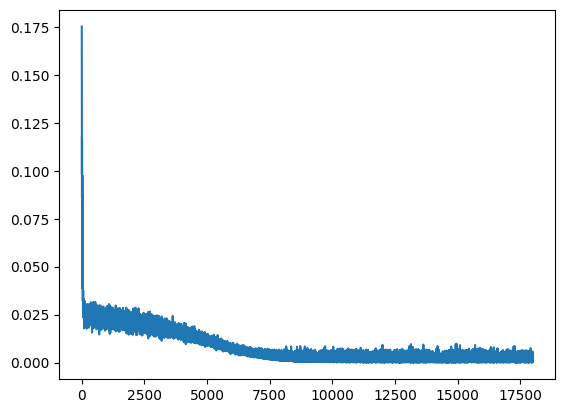

In [ ]:
# Training 

num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm = LSTMModel(num_classes, input_size, hidden_size, num_layers)
loss_list = []
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)


for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = lstm(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

plt.plot(loss_list)



[[0.01310288]
 [0.0131108 ]
 [0.01310941]
 [0.01310892]
 [0.01312216]
 [0.01310369]
 [0.01310947]
 [0.01311759]
 [0.01311682]
 [0.01313457]
 [0.01313546]
 [0.01314484]
 [0.01315298]
 [0.01313092]
 [0.01316318]
 [0.01313199]
 [0.01316209]
 [0.01315191]
 [0.01311497]
 [0.013113  ]
 [0.01312344]
 [0.04052227]
 [0.10620423]
 [0.13410495]
 [0.1466989 ]
 [0.15204042]
 [0.15101348]
 [0.15096478]
 [0.1500899 ]
 [0.14999595]
 [0.14897487]
 [0.14911686]
 [0.14957583]
 [0.1502537 ]
 [0.14936699]
 [0.15017095]
 [0.15137577]
 [0.15103294]
 [0.15246387]
 [0.15330127]
 [0.15404178]
 [0.15531994]
 [0.22152673]
 [0.18914759]
 [0.17356911]
 [0.16579618]
 [0.15872149]
 [0.15890396]
 [0.16112718]
 [0.16179127]
 [0.16094714]
 [0.16151896]
 [0.16125292]
 [0.16255814]
 [0.16303995]
 [0.16212592]
 [0.16270971]
 [0.16372517]
 [0.16358519]
 [0.16494167]
 [0.16519713]
 [0.16466501]
 [0.16512236]
 [0.11809602]
 [0.14521539]
 [0.15860057]
 [0.16438799]
 [0.16987002]
 [0.17009655]
 [0.17106795]
 [0.17111392]
 [0.17

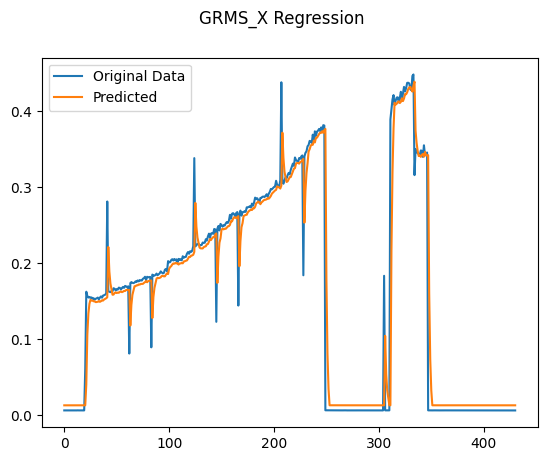

In [ ]:
# Evaluate
#with torch.no_grad():
#    lstm.eval()
#    train_pred = lstm(dataX)
   
#    data_pred = train_pred.data.numpy()
#    dataY_plot = dataY.data.numpy()


#    plt.plot(dataY_plot)
#    plt.plot(data_pred)
#    plt.suptitle('GRMS_X Regression')
#    plt.show()
    

# Evaluate

with torch.no_grad():
    lstm.eval()
    dataX, dataY = test_dataset.tensors
    dataX, dataY = dataX.to(device), dataY.to(device)
    train_pred = lstm(dataX)
    data_pred = train_pred.data.cpu().data.numpy()
    print(data_pred)
    dataY_plot = dataY.data.cpu().numpy()

plt.plot(dataY_plot, label='Original Data')
plt.plot(data_pred, label='Predicted')
plt.legend()
plt.suptitle('GRMS_X Regression')
plt.show()

In [ ]:
# increase num classes
# change loss Cross entropy loss yap
# traini shuffle yap teste gerek yok shufflelayadabilirz